## Importing Libraries

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import librosa
import glob
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from scipy import signal

## Visualizations 

In [4]:
def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=480, hop_length=160,
                     win_length=480, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect

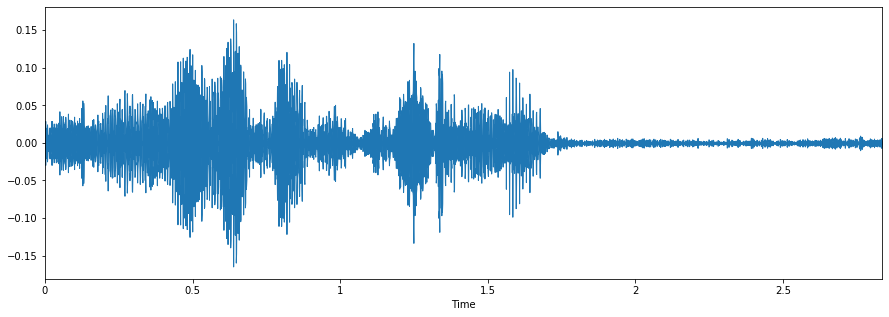

In [7]:
# Raw wav file
data, sampling_rate = librosa.load('meld/train/disgust/MEL_dia1005_utt6_negative_DIS.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

spectrogram shape: (241, 377)


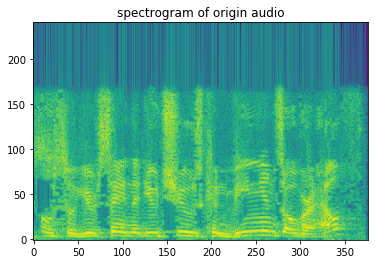

In [5]:
# Spectrogram of audio
wav, sr = librosa.load('meld/train/disgust/MEL_dia1005_utt13_negative_DIS.wav')
log_spect = np.log(get_spectrogram(wav))
print('spectrogram shape:', log_spect.shape)
plt.imshow(log_spect, aspect='auto', origin='lower',)
plt.title('spectrogram of origin audio')
plt.show()

In [2]:
L=16000
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Function for padding smaller wave files
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))
    
# Function for choppipng larger wave files
def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def get_spectrogram(wav):
    D = librosa.stft(wav, n_fft=480, hop_length=160,
                     win_length=480, window='hamming')
    spect, phase = librosa.magphase(D)
    return spect

## Train and validation set generation

In [23]:
new_sample_rate = 16000
y_train = []
x_train = []
mylist1=os.listdir('meld/train/')
for file in mylist1:
    mylist= os.listdir('meld/train/'+file+"/")
    for index,y in enumerate(mylist):
        # Loading the wave files
        samples, sample_rate = librosa.load('meld/train/'+file+"/"+y,mono=True,sr=16000)
        samples = pad_audio(samples)
        if len(samples) > 16000:
            n_samples = chop_audio(samples)
        else: n_samples = [samples]
        for samples in n_samples:
            # Resampling the wave files
            resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
            x_train.append(samples)
            y_train.append(file)
# Converting training files to numpy array
x_train = np.array(x_train)
x_train = pd.DataFrame(x_train)
lb = LabelEncoder()
y_train =lb.fit_transform(y_train)

In [24]:
# Converting train dataset into a DataFrame
x_train["labels"]=y_train
x_train=x_train.fillna(0)
rnewdf = shuffle(x_train)
rnewdf.reset_index(inplace=True)
rnewdf.drop("index",inplace=True,axis=1)
y_train=rnewdf["labels"]
rnewdf.drop("labels",inplace=True,axis=1)

In [25]:
new_sample_rate = 16000
y_test = []
x_test = []
mylist1=os.listdir('meld/val/')
for file in mylist1:
    mylist= os.listdir('meld/val/'+file+"/")
    for index,y in enumerate(mylist):
        # Loadingthe wave files
        samples, sample_rate = librosa.load('meld/val/'+file+"/"+y,mono=True,sr=16000)
        #samples=np.array(samples*32768,dtype = "int16")
        samples = pad_audio(samples)
        if len(samples) > 16000:
            n_samples = chop_audio(samples)
        else: n_samples = [samples]
        for samples in n_samples:
            # Resampling the wave files
            resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
            # Log specgrams of wave files
            #_, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
            x_test.append(samples)
            y_test.append(file)
# Converting training files to numpy array
x_test = np.array(x_test)
x_test = pd.DataFrame(x_test)
y_test =lb.fit_transform(y_test)

## Training LightGBM

In [26]:
import lightgbm as lgb

In [30]:
lgtrain, lgval = lgb.Dataset(rnewdf, y_train), lgb.Dataset(x_test, y_test)

In [31]:
params = {
          "objective" : "multiclass",
          "num_class" : 5,
 }

In [ ]:
lgbmodel = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)


In [ ]:
predictions=lgbmodel.predict(test)

In [ ]:
predictionsfinal=[]
for x in predictions:
    predictionsfinal.append(np.argmax(x))